<a href="https://colab.research.google.com/github/emguz/CSE-151A-Project/blob/main/CSE_151A_Project_hot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# CSV File Upload

In [2]:
# all_data_csv = glob.glob("data/*.csv")
from google.colab import files
# Choosing Kaggle key file from local computer
# To get a kaggle key, you have to log into your kaggle account and go to your account settings
# Scroll down to the API section and create a new token
# You should be able to download a file named 'kaggle' and this is the one you upload
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nicholasjobe","key":"2bc6a9d3cfd2aaa329682ac2257596bd"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d mexwell/nba-shots

Dataset URL: https://www.kaggle.com/datasets/mexwell/nba-shots
License(s): other
 82% 66.0M/80.4M [00:00<00:00, 246MB/s]
100% 80.4M/80.4M [00:00<00:00, 228MB/s]


In [5]:
!unzip \*.zip && rm *.zip

Archive:  nba-shots.zip
  inflating: NBA_2004_Shots.csv      
  inflating: NBA_2005_Shots.csv      
  inflating: NBA_2006_Shots.csv      
  inflating: NBA_2007_Shots.csv      
  inflating: NBA_2008_Shots.csv      
  inflating: NBA_2009_Shots.csv      
  inflating: NBA_2010_Shots.csv      
  inflating: NBA_2011_Shots.csv      
  inflating: NBA_2012_Shots.csv      
  inflating: NBA_2013_Shots.csv      
  inflating: NBA_2014_Shots.csv      
  inflating: NBA_2015_Shots.csv      
  inflating: NBA_2016_Shots.csv      
  inflating: NBA_2017_Shots.csv      
  inflating: NBA_2018_Shots.csv      
  inflating: NBA_2019_Shots.csv      
  inflating: NBA_2020_Shots.csv      
  inflating: NBA_2021_Shots.csv      
  inflating: NBA_2022_Shots.csv      
  inflating: NBA_2023_Shots.csv      
  inflating: NBA_2024_Shots.csv      


In [6]:
# Consolidating all csv files
import os
file_names = os.listdir()
all_data_csv = [file for file in file_names if file.endswith('.csv')]

In [7]:
dfs_combine = []

# for each file, add to dfs_combine
for file in all_data_csv:
    df = pd.read_csv(file)
    dfs_combine.append(df)

# join dfs together
df_all_data = pd.concat(dfs_combine, ignore_index=True)

# save combined dfs into new file
df_all_data.to_csv('all_years.csv', index=False)

In [8]:
# removes the individual year csv files from directory
for file in all_data_csv:
  os.remove(file)


# Exploration

In [9]:
data = pd.read_csv('all_years.csv')

In [10]:
print('Data Columns: ')
print(data.columns)
print('Data Shape: ')
print(data.shape)

Data Columns: 
Index(['SEASON_1', 'SEASON_2', 'TEAM_ID', 'TEAM_NAME', 'PLAYER_ID',
       'PLAYER_NAME', 'POSITION_GROUP', 'POSITION', 'GAME_DATE', 'GAME_ID',
       'HOME_TEAM', 'AWAY_TEAM', 'EVENT_TYPE', 'SHOT_MADE', 'ACTION_TYPE',
       'SHOT_TYPE', 'BASIC_ZONE', 'ZONE_NAME', 'ZONE_ABB', 'ZONE_RANGE',
       'LOC_X', 'LOC_Y', 'SHOT_DISTANCE', 'QUARTER', 'MINS_LEFT', 'SECS_LEFT'],
      dtype='object')
Data Shape: 
(4231262, 26)


In [11]:
data.head()

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,BASIC_ZONE,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
0,2017,2016-17,1610612765,Detroit Pistons,202397,Ish Smith,G,PG,04-12-2017,21601217,...,Above the Break 3,Right Side Center,RC,24+ ft.,-17.9,23.55,25,4,0,7
1,2017,2016-17,1610612752,New York Knicks,1627850,Marshall Plumlee,C,C,04-12-2017,21601220,...,Restricted Area,Center,C,Less Than 8 ft.,-0.0,7.25,2,2,6,10
2,2017,2016-17,1610612752,New York Knicks,1627851,Mindaugas Kuzminskas,F,SF,04-12-2017,21601220,...,Mid-Range,Right Side Center,RC,16-24 ft.,-14.2,18.45,19,1,2,3
3,2017,2016-17,1610612760,Oklahoma City Thunder,202708,Norris Cole,G,PG,04-12-2017,21601225,...,Above the Break 3,Center,C,24+ ft.,-2.8,29.65,24,4,0,34
4,2017,2016-17,1610612752,New York Knicks,1626254,Maurice Ndour,F,PF,04-12-2017,21601220,...,Restricted Area,Center,C,Less Than 8 ft.,-0.5,6.55,1,1,9,53


In [12]:
for attribute in data.columns:
    print('-----' + attribute + '-----')
    print(data[attribute].unique())
    print('\n')

-----SEASON_1-----
[2017 2018 2005 2014 2024 2016 2011 2009 2020 2021 2006 2004 2008 2010
 2015 2022 2012 2019 2007 2013 2023]


-----SEASON_2-----
['2016-17' '2017-18' '2004-05' '2013-14' '2023-24' '2015-16' '2010-11'
 '2008-09' '2019-20' '2020-21' '2005-06' '2003-04' '2007-08' '2009-10'
 '2014-15' '2021-22' '2011-12' '2018-19' '2006-07' '2012-13' '2022-23']


-----TEAM_ID-----
[1610612765 1610612752 1610612760 1610612755 1610612753 1610612743
 1610612763 1610612741 1610612751 1610612747 1610612744 1610612749
 1610612740 1610612750 1610612738 1610612757 1610612745 1610612742
 1610612739 1610612761 1610612759 1610612764 1610612748 1610612737
 1610612754 1610612762 1610612758 1610612746 1610612756 1610612766]


-----TEAM_NAME-----
['Detroit Pistons' 'New York Knicks' 'Oklahoma City Thunder'
 'Philadelphia 76ers' 'Orlando Magic' 'Denver Nuggets' 'Memphis Grizzlies'
 'Chicago Bulls' 'Brooklyn Nets' 'Los Angeles Lakers'
 'Golden State Warriors' 'Milwaukee Bucks' 'New Orleans Pelicans'
 'Mi

In [13]:
# ['SEASON_1', 'SEASON_2', 'TEAM_ID', 'TEAM_NAME', 'PLAYER_ID',
#  'PLAYER_NAME', 'POSITION_GROUP', 'POSITION', 'GAME_DATE', 'GAME_ID',
#  'HOME_TEAM', 'AWAY_TEAM', 'EVENT_TYPE', 'SHOT_MADE', 'ACTION_TYPE',
#  'SHOT_TYPE', 'BASIC_ZONE', 'ZONE_NAME', 'ZONE_ABB', 'ZONE_RANGE',
#  'LOC_X', 'LOC_Y', 'SHOT_DISTANCE', 'QUARTER', 'MINS_LEFT', 'SECS_LEFT']

# data already clean -> separate into attribute categories

pred_attrib = ['EVENT_TYPE', 'SHOT_MADE']
numerical_attrib = ['SEASON_1', 'TEAM_ID', 'PLAYER_ID', 'GAME_ID', 'LOC_X', 'LOC_Y', 'SHOT_DISTANCE', 'QUARTER', 'MINS_LEFT', 'SECS_LEFT']
categorical_attrib = list(set(data.columns) - set(pred_attrib) - set(numerical_attrib))

<Axes: >

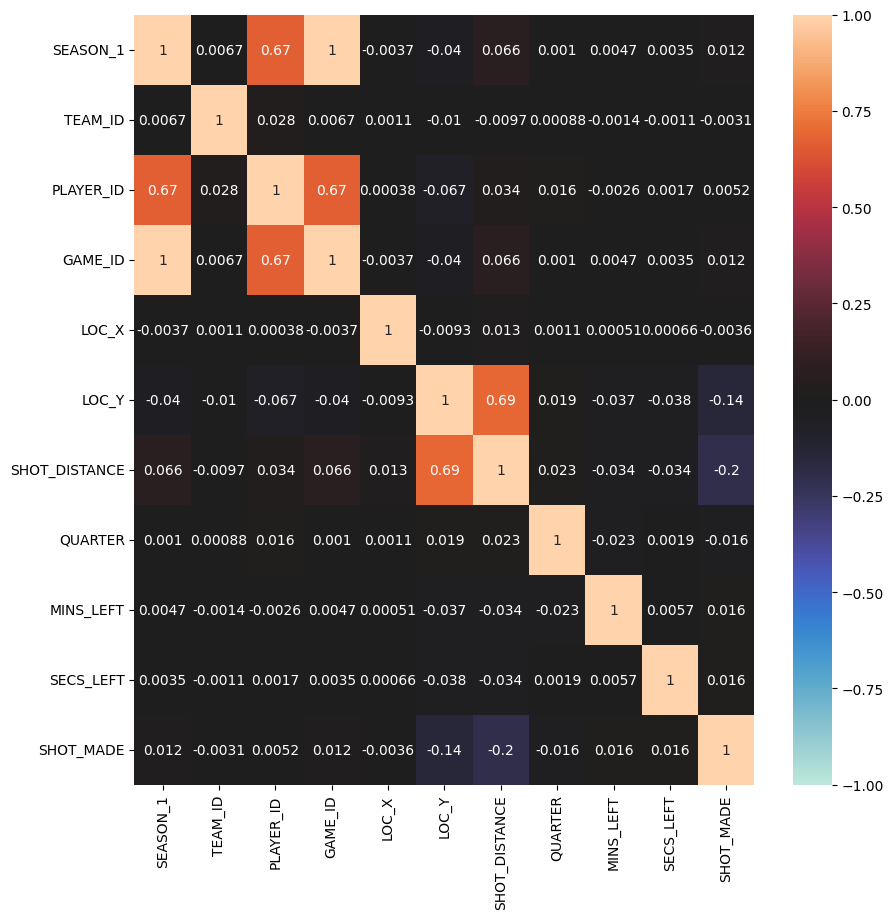

In [14]:
# heatmap w/ numerical attributes

# make figure larger
fig, ax = plt.subplots(figsize=(10,10))

heat_vars = numerical_attrib.copy()
heat_vars.append('SHOT_MADE')
sns.heatmap(data[heat_vars].corr(), annot=True,vmin=-1, vmax=1, center= 0, ax=ax)

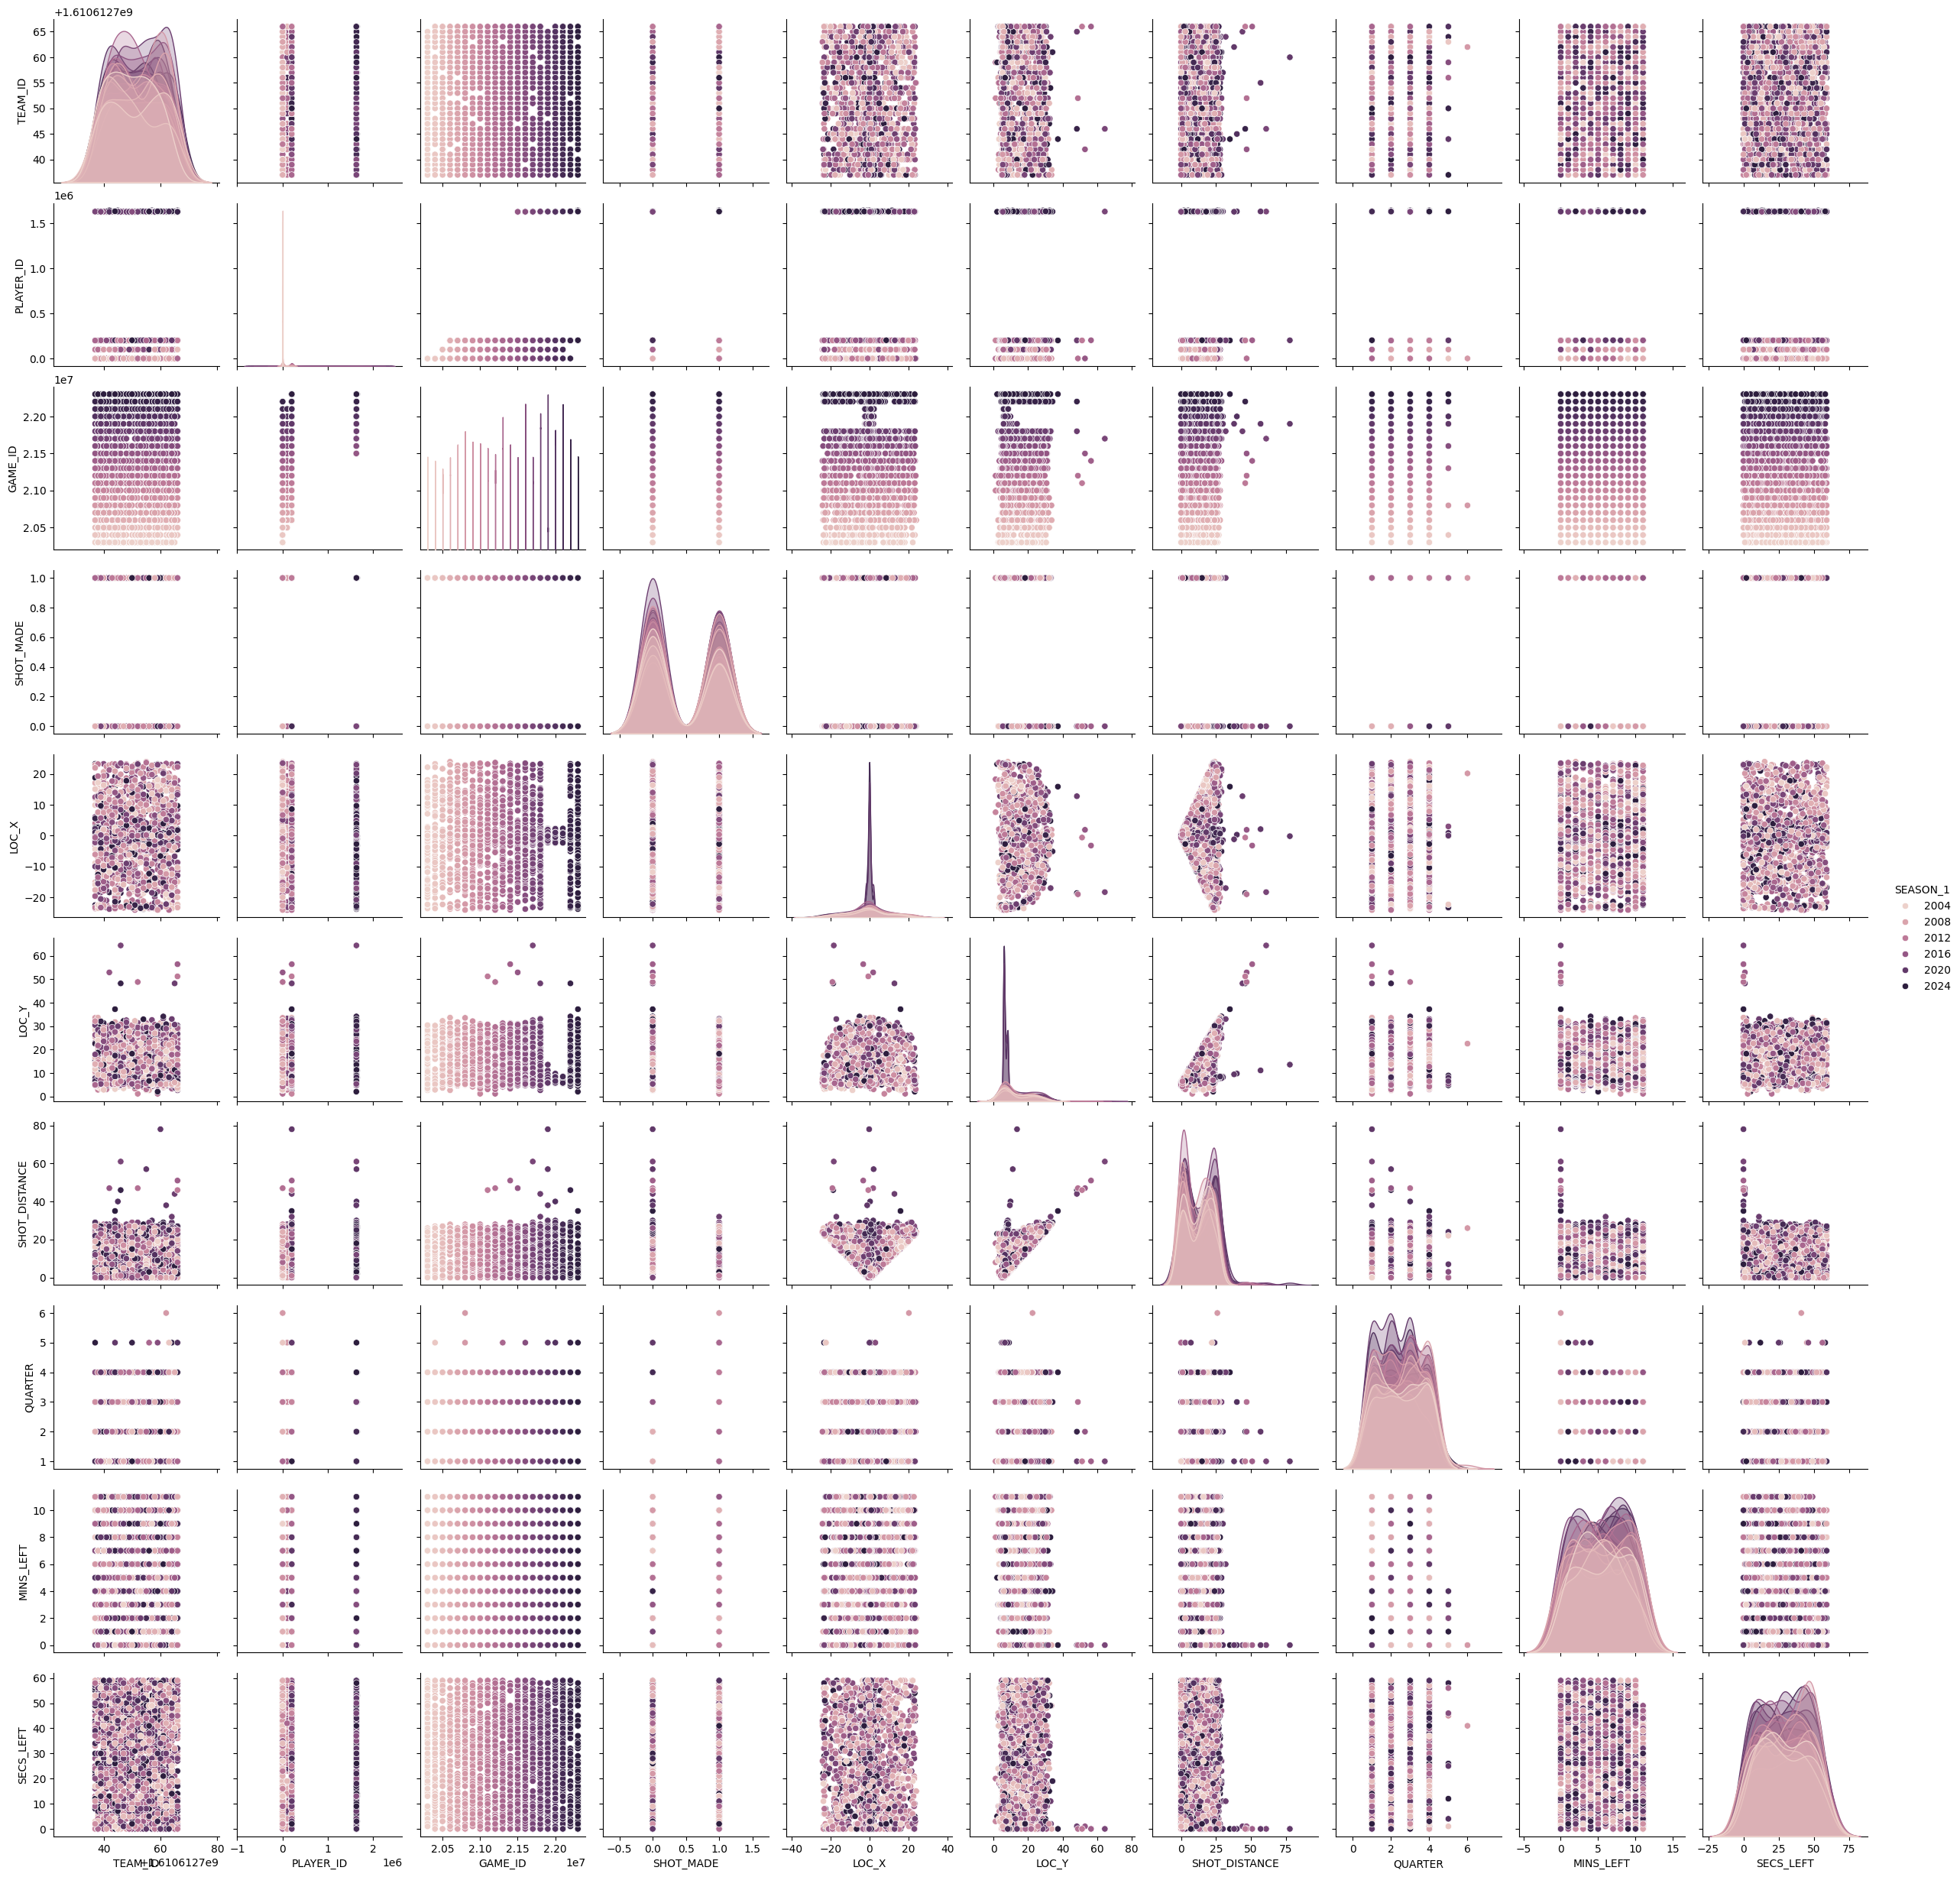

In [15]:
# pairplot with sample of data
sample = data.sample(int(len(data) * 0.0005))
sns.pairplot(sample, hue='SEASON_1', diag_kind='auto')

# Pre-Processing

In [16]:
print(data.columns)

Index(['SEASON_1', 'SEASON_2', 'TEAM_ID', 'TEAM_NAME', 'PLAYER_ID',
       'PLAYER_NAME', 'POSITION_GROUP', 'POSITION', 'GAME_DATE', 'GAME_ID',
       'HOME_TEAM', 'AWAY_TEAM', 'EVENT_TYPE', 'SHOT_MADE', 'ACTION_TYPE',
       'SHOT_TYPE', 'BASIC_ZONE', 'ZONE_NAME', 'ZONE_ABB', 'ZONE_RANGE',
       'LOC_X', 'LOC_Y', 'SHOT_DISTANCE', 'QUARTER', 'MINS_LEFT', 'SECS_LEFT'],
      dtype='object')


In [17]:
# Dropping redundant attributes
Preprocessed_Data = data.drop('SEASON_2', axis=1)
Preprocessed_Data = Preprocessed_Data.drop('TEAM_NAME', axis=1)
Preprocessed_Data = Preprocessed_Data.drop('PLAYER_NAME', axis=1)
Preprocessed_Data = Preprocessed_Data.drop('POSITION', axis=1)
Preprocessed_Data = Preprocessed_Data.drop('GAME_DATE', axis=1)
Preprocessed_Data = Preprocessed_Data.drop('EVENT_TYPE', axis=1)
Preprocessed_Data = Preprocessed_Data.drop('ZONE_NAME', axis=1)

In [18]:
# Encoding Categorical data

attributes_to_encode = ['POSITION_GROUP', 'HOME_TEAM', 'AWAY_TEAM', 'ACTION_TYPE', 'SHOT_TYPE', 'BASIC_ZONE', 'ZONE_ABB', 'ZONE_RANGE']

for attribute in attributes_to_encode:
  encoding = 0
  observations = Preprocessed_Data[attribute].unique()
  for observation in observations:
    if pd.isna(observation): # Checks for NAN
      Preprocessed_Data.loc[Preprocessed_Data[attribute].isna(), attribute] = -1
    else:
      Preprocessed_Data.loc[Preprocessed_Data[attribute] == observation, attribute] = encoding
      encoding += 1

In [19]:
# Further Exploration

Preprocessed_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4231262 entries, 0 to 4231261
Data columns (total 19 columns):
 #   Column          Dtype  
---  ------          -----  
 0   SEASON_1        int64  
 1   TEAM_ID         int64  
 2   PLAYER_ID       int64  
 3   POSITION_GROUP  object 
 4   GAME_ID         int64  
 5   HOME_TEAM       object 
 6   AWAY_TEAM       object 
 7   SHOT_MADE       bool   
 8   ACTION_TYPE     object 
 9   SHOT_TYPE       object 
 10  BASIC_ZONE      object 
 11  ZONE_ABB        object 
 12  ZONE_RANGE      object 
 13  LOC_X           float64
 14  LOC_Y           float64
 15  SHOT_DISTANCE   int64  
 16  QUARTER         int64  
 17  MINS_LEFT       int64  
 18  SECS_LEFT       int64  
dtypes: bool(1), float64(2), int64(8), object(8)
memory usage: 585.1+ MB


<Axes: >

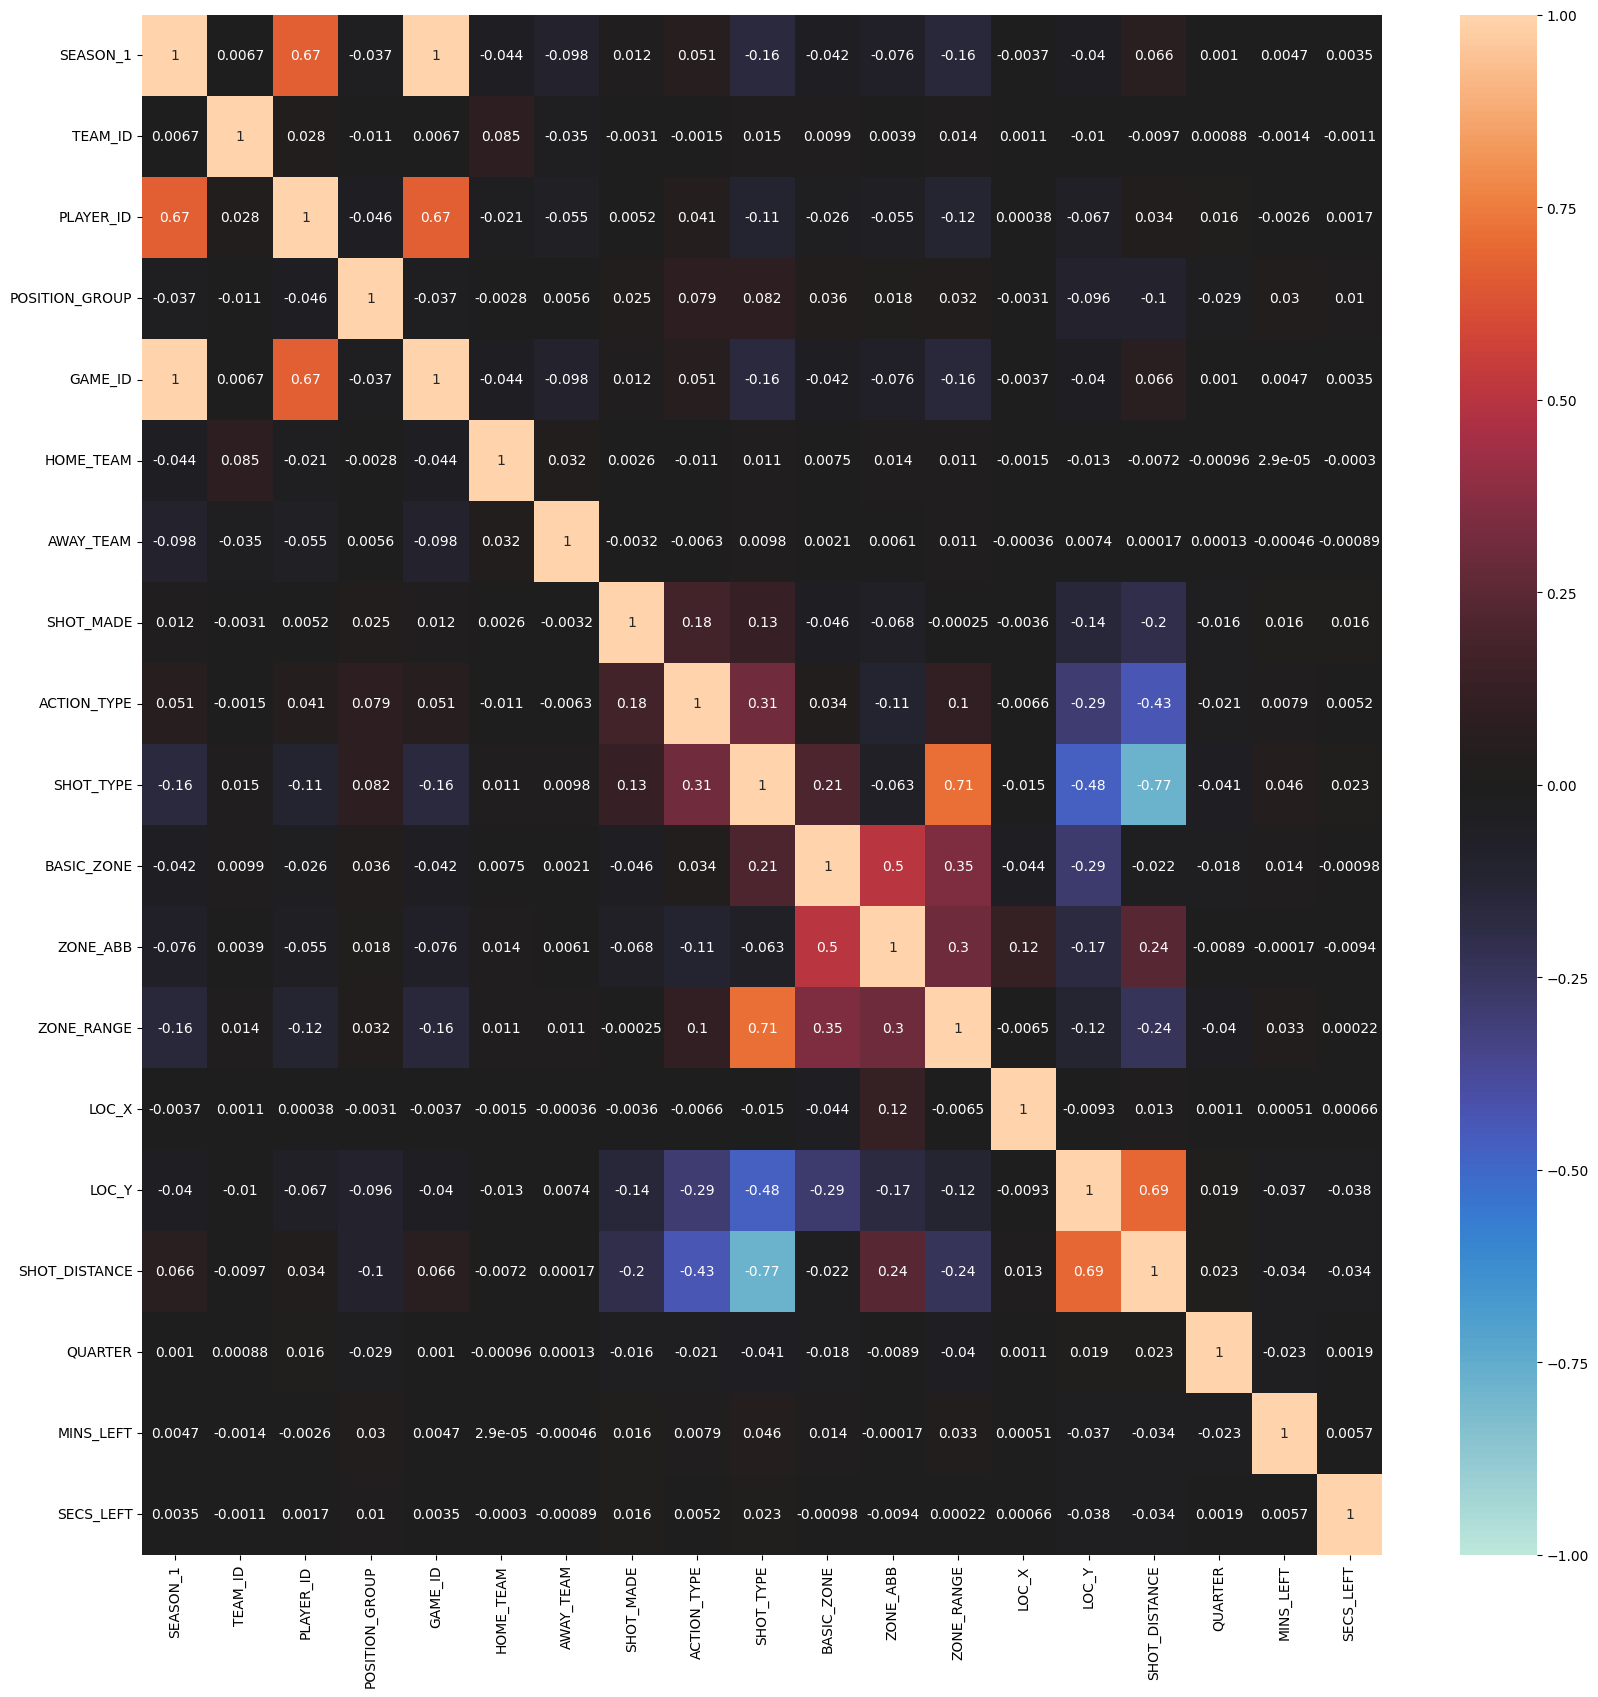

In [20]:
# heatmap w/ preprocessed attributes

# make figure larger
fig, ax = plt.subplots(figsize=(20,20))

attributes = list(Preprocessed_Data.columns)
heat_vars = attributes.copy()
sns.heatmap(Preprocessed_Data[heat_vars].corr(), annot=True,vmin=-1, vmax=1, center= 0, ax=ax)

In [21]:
# Zone Range and shot type are highly correlated, dropping shot dist
Preprocessed_Data = Preprocessed_Data.drop(columns='SHOT_DISTANCE', axis=1)

# Also dropping Season_1 and Game_ID
Preprocessed_Data = Preprocessed_Data.drop(columns='GAME_ID', axis=1)
Preprocessed_Data = Preprocessed_Data.drop(columns='SEASON_1', axis=1)

<Axes: >

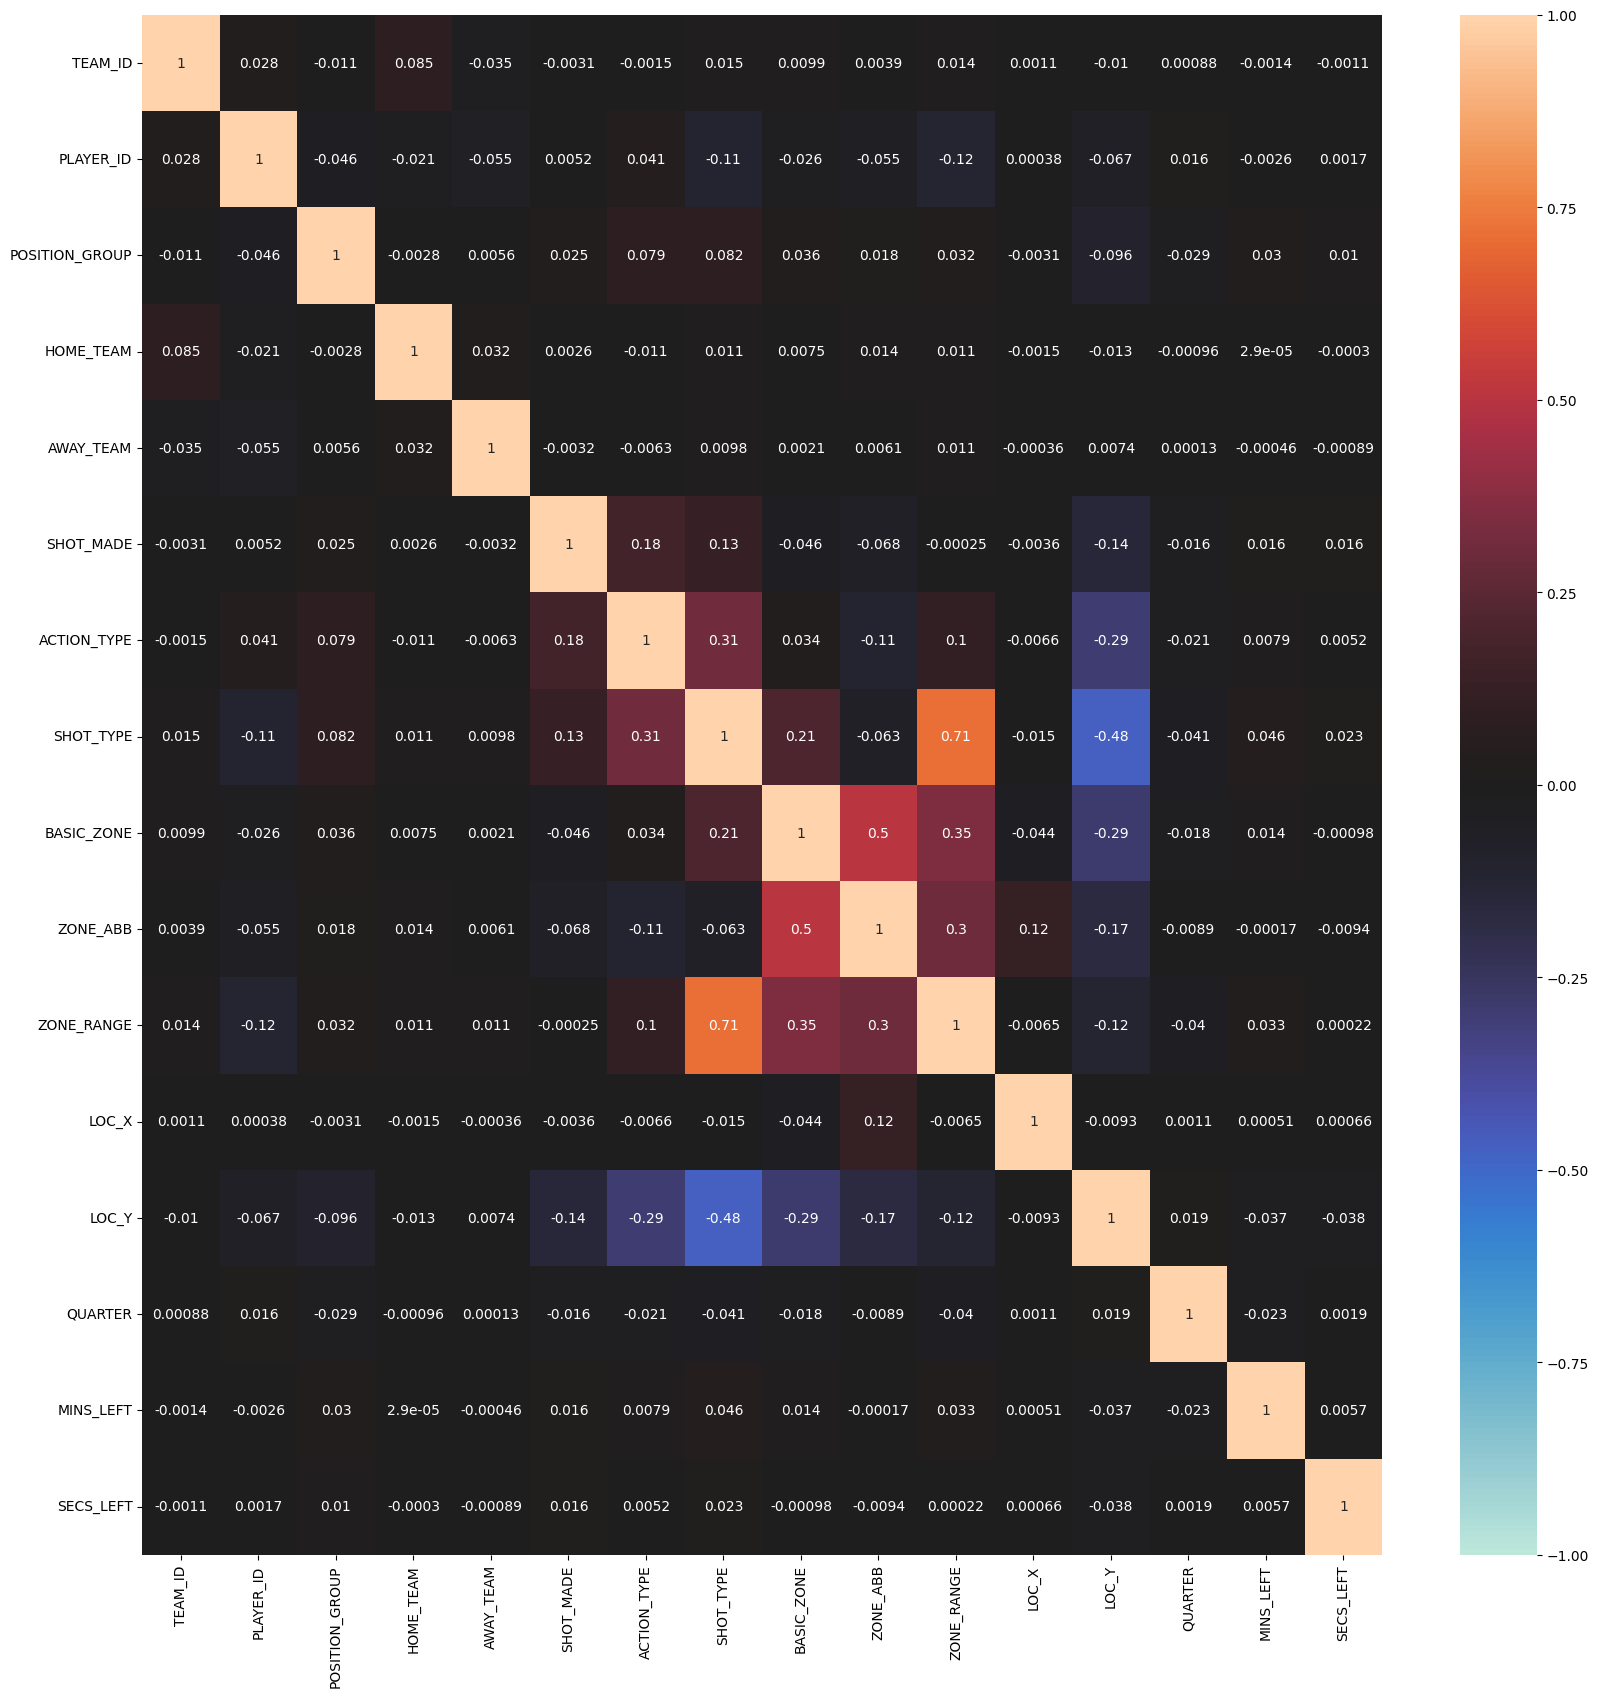

In [22]:
# Second heatmap to check for other highly correlated values

fig, ax = plt.subplots(figsize=(20,20))

attributes = list(Preprocessed_Data.columns)
heat_vars = attributes.copy()
sns.heatmap(Preprocessed_Data[heat_vars].corr(), annot=True,vmin=-1, vmax=1, center= 0, ax=ax)

# First Model

In [23]:
# Splitting data (20/80 split)
y = Preprocessed_Data.SHOT_MADE
x = Preprocessed_Data.drop('SHOT_MADE', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=21)

# Checking if our data has the right dimensions
print('xTrain shape:', x_train.shape)
print('yTrain shape:', y_train.shape)
print('xTest shape:', x_train.shape)
print('yTest shape:', y_test.shape)

xTrain shape: (3385009, 15)
yTrain shape: (3385009,)
xTest shape: (3385009, 15)
yTest shape: (846253,)


In [24]:
# Scaling data
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import OneHotEncoder

x_numerical_columns = ['TEAM_ID', 'PLAYER_ID', 'LOC_X', 'LOC_Y', 'QUARTER', 'MINS_LEFT', 'SECS_LEFT']
x_categorical_columns = ['POSITION_GROUP', 'HOME_TEAM', 'AWAY_TEAM', 'ACTION_TYPE', 'SHOT_TYPE', 'BASIC_ZONE', 'ZONE_ABB', 'ZONE_RANGE']

# Scaling numerical data
scaler = StandardScaler()
scaler.fit(Preprocessed_Data[x_numerical_columns])
# x_test_numerical = scaler.transform(x_test_numerical)

StandardScaler()

In [25]:
# Encoding categorical data
# make sparse_output=False to ensure a numpy array for an ouput, will be useful for concatenating data
# one_hot_encoder = OneHotEncoder(sparse_output=False)
preprocessed_hot = pd.get_dummies(Preprocessed_Data, columns= x_categorical_columns)
x_train, x_test, y_train, y_test = train_test_split(preprocessed_hot.drop('SHOT_MADE', axis=1), preprocessed_hot.SHOT_MADE, test_size=0.2, random_state=21)

x_train_numerical = scaler.transform(x_train[x_numerical_columns])
x_test_numerical = scaler.transform(x_test[x_numerical_columns])
x_train_numerical = pd.DataFrame(x_train_numerical, columns=x_numerical_columns, index=x_train.index)
x_test_numerical = pd.DataFrame(x_test_numerical, columns=x_numerical_columns, index=x_test.index)
x_train_scaled = x_train.copy()
x_test_scaled = x_test.copy()
x_train_scaled[x_numerical_columns] = x_train_numerical
x_test_scaled[x_numerical_columns] = x_test_numerical

In [26]:
print('Encoded and scaled data: ')
print(x_train_scaled.head())
print(' x_train shape: ', x_train_scaled.shape)
print(' x_test shape: ', x_test_scaled.shape)

Encoded and scaled data: 
          TEAM_ID  PLAYER_ID     LOC_X     LOC_Y   QUARTER  MINS_LEFT  \
3191574 -1.213139   1.974743  0.086228 -0.518449 -0.422553  -1.253089   
3368676  1.449637  -0.343538 -1.217185  0.649942  0.456569   0.479510   
1956415 -0.634275   1.974764  0.082331 -0.505590  0.456569  -0.964322   
344294  -0.171183  -0.340924  0.205074 -0.483964 -1.301674   0.479510   
2906841 -1.213139  -0.342904 -0.642437  0.556424 -0.422553   1.634577   

         SECS_LEFT  POSITION_GROUP_-1  POSITION_GROUP_0  POSITION_GROUP_1  \
3191574  -0.674600              False              True             False   
3368676   1.617726              False             False             False   
1956415   0.471563              False              True             False   
344294    0.586179              False             False             False   
2906841  -1.133066              False              True             False   

         ...  ZONE_ABB_1  ZONE_ABB_2  ZONE_ABB_3  ZONE_ABB_4  ZONE_ABB_5

In [27]:
# Updating x_train and x_test arrays
x_train = x_train_scaled
x_test = x_test_scaled

# Checking if our data has the right dimensions
print('xTrain shape:', x_train.shape)
print('yTrain shape:', y_train.shape)
print('xTest shape:', x_test.shape)
print('yTest shape:', y_test.shape)

xTrain shape: (3385009, 169)
yTrain shape: (3385009,)
xTest shape: (846253, 169)
yTest shape: (846253,)


In [28]:
# Training first model (Logistic Regression)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logisticModel = LogisticRegression(max_iter=1000)
logisticModel = logisticModel.fit(x_train, y_train)

# Evaluating Model
y_train_pred = logisticModel.predict(x_train)
y_test_pred = logisticModel.predict(x_test)

# Printing Reports

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.62      0.84      0.71    459481
        True       0.67      0.38      0.48    386772

    accuracy                           0.63    846253
   macro avg       0.64      0.61      0.60    846253
weighted avg       0.64      0.63      0.61    846253



In [29]:
# TODO
# Fill in NAN values (making this a seperate ) [DONE]
# Second data exploration round, i.e. heat map [DONE]
# Get rid of attributes that correlate too much [DONE]
# Scale numerical attributes [DONE]
# One-hot-encode unordered(all of them) categorical values [DONE]
# Run first model (logistic regression) [DONE]
# Evaluate model, compare training vs test error [DONE]
# Answer 4-6 in write up

# Printing

In [30]:
!apt-get update

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,482 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,614 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,164 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,701 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,425 

In [31]:
!pip install nbconvert
!apt-get install pandoc
!apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3 pandoc-data
Suggested packages:
  texlive-latex-recommended texlive-xetex texlive-luatex pandoc-citeproc texlive-latex-extra
  context wkhtmltopdf librsvg2-bin groff ghc nodejs php python ruby libjs-mathjax libjs-katex
  citation-style-language-styles
The following NEW packages will be installed:
  libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3 pandoc pandoc-data
0 upgraded, 4 newly installed, 0 to remove and 7 not upgraded.
Need to get 20.6 MB of archives.
After this operation, 156 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcmark-gfm0.29.0.gfm.3 amd64 0.29.0.gfm.3-3 [115 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcmark-gfm-extensions0.29.0.gfm.3 amd64 0.29.0.gfm.3-3 [25.1 kB]
G

In [32]:
!jupyter nbconvert --to pdf "/content/drive/MyDrive/CSE-151A-Project/CSE_151A_Project.ipynb"

[NbConvertApp] WARNING | pattern '/content/drive/MyDrive/CSE-151A-Project/CSE_151A_Project.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: